# Neural Network
The concept of neural network is probably quite familar to everybody. If not, the information is readily available online. I am not going to write too much about the introduction to neural networks. I am primarily focusing on the implementation and mathematics behind **feed-forward neural network**.

## Forward Propagation
### Affine 
Given an input vector or matrix, we forward propagate through the network by applying matrix multiplication to the input by a set of weight. In many textbook examples, like the diagram below:

![Neural Netowrk](./assets/neural_network.png)

The diagram is actually overcomplicating things a little bit. Although the diagram is accurately depicting what's happening to a set of input when it is being forward propagated through a network, if we are using the concept of **computational graph** and vectorized implementation, the whole operation can be summarized more succintly, like the following:

![Computational Graph](./assets/comp_graph.png)

So what is affine? Affine refers to the linear mapping from input to output. Simply put, it is just a matrix multiplication as I mentioned above.

In [1]:
import numpy as np
np.random.seed(314)

# Declare an input
x = np.array([1, 2, 3])

# Declare a weight matrix and a bias vector, I will use random values here
W = np.random.rand(3, 3)
b = np.random.rand(3,)

# Affine transformation using array broadcasting on the bias part
x.dot(W) + b 

array([ 4.92789534,  3.97236133,  4.91657911])

### Activation
Activation is also called non-linearity. As you can see that affine transformation is a linear operation. It multiplies the vector with some numbers and then sum up the contributions. If this is all we do throughout the network, then we are losing a lot of flexibility. Thus, we must introduce non-linear activation functions to the network to give it the power to learn non-linear behavior. 

There are many activation functions we can use, `sigmoid`, `tanh`, `rectified linear unit`, and etc... For now, I will focus on just **sigmoid** activation function. Sigmoid function has a range from 0 to 1. When the input is negative and big in magnitude, the output is 0. When input is positive and big in magnitude, the output is 1.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

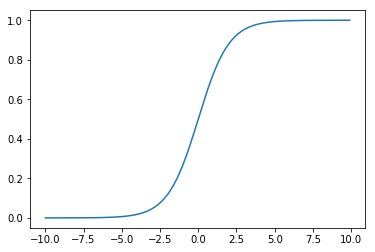

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  


def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)

plt.plot(x, y)
plt.show()

### Put them together
Put everything together and we can construct a simple neural network with an input, a hidden, and an output layer. Assuming that the input dimension is 3, hidden dimension is 4 and output dimension is 2, identical to the first diagram on this page.

In [3]:
# Input is x
x = np.array([[1, 2, 3]])

# Initialized two weight matrices, one for input to hidden, another one for hidden to output.
W1 = np.random.rand(3, 4)
b1 = np.random.rand(4,)

W2 = np.random.rand(4, 2)
b2 = np.random.rand(2,)

# Forward propagation
x = x.dot(W1) + b1
x = sigmoid(x)
x = x.dot(W2) + b2
x = sigmoid(x)

print x

[[ 0.76744569  0.89594611]]


So this is it, that's how you do a forward propagation. You just keep adding layers and layers of affine transformation and sigmoid activation if you want a deep neural network.

## Loss
So far the neural network I have produced with random weights is a garbage. It does not provide any accurate prediction. We need a way to train it. Before we train it, we need a way to identify and evaluate the fitness of our model. Loss function is a way for us to quantify how far off are the predictions of a model from the real data. There are many different types of loss function depending on the task. For example, for classification problem, we can use **hinge loss**, or **cross entropy loss**. For regression problems, we can use **L2 loss**, **L1 loss**, or **mean squared error loss**. 

We will focus on cross entropy loss and mean squared error loss here. Cross entropy loss typically goes with softmax activation. However, softmax activation is not the usual activation you'd see that occurs in every layer. Softmax activation is meant for the output layer when we try to compute probability for classification, like given an input image, what is the probability of the image being a cat image or dog image? 

### Softmax Activation & Loss
Given a vector of score for each class, assuming that this is the output of the neural network, denoted as `y`, `y[i]` is the score for ith class. The probability of being classified as ith class is:

$$
P(i) = \frac{e^{y_{i}}}{\Sigma_{j} e^{y_{j}}}
$$

In [4]:
# Using x from previous example
def softmax(x):
    """Numerically stable softmax probabilities"""
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))
    
probs = softmax(x)
print np.sum(probs) # Should be very close to one
print probs

1.0
[[ 0.46791903  0.53208097]]


The loss function for softmax is 

$$
L_{i} = -log\left( \frac{e^{y_{i}}}{\Sigma_{j} e^{y_{j}}} \right)
$$

$$
L = \Sigma_{i} L_{i}
$$

In [5]:
def softmax_loss(P, labels):
    N, _ = P.shape
    return -np.sum(np.log(P[np.arange(N), labels])) / N
    
print softmax_loss(probs, [1])

0.630959599239


### Mean Squared Error Loss
This one is simple, instead of computing softmax probability, take the score and treat it as the raw output. The vector of scores could be anything like stock prices, housing prices, animal weight/height, anything you can think of. The loss function takes into account for the difference between the expected results and predicted results. Let's say **y hat** is our prediction vector then loss function can be written as:

$$
L = \frac{1}{N} \sum (\hat{y}_{i} - y_{i})^{2}
$$

## Backpropagation
Now we have a way to measure the fitness of our model, we can proceed to train it using gradient descent or other more advanced optimization technique. I will stick to the simplest. In order to perform gradient descent, we must first compute the gradients for every layer of forward propagation and then perform back propagation from output layer all the way back to input layer. 

### Softmax Gradient
We will compute the gradient of softmax loss with respect to score first. I am not going to derive the mathematics of derivatives of a softmax loss because it is a bit length to type and you can find it on https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function. The derived result is very elegant, we can compute the gradient within 3 lines of code.

```python
# P is the matrix of probabilities
grad_score = P.copy()
grad_score[np.arange(N), labels] -= 1
grad_score /= N
```

### Means Squared Error Gradient
The mean squared error gradient derivation is quite easy to type and express. Here it is:

$$
\frac{\partial L}{\partial \hat{y}} = 2 \cdot (\hat{y} - y)
$$

```python
# Treat y_hat as the output of our neural network
grad_output = 2.0 * (output - y)
```

### Sigmoid Gradient
The derivative of sigmoid function is:

$$
\frac{\partial \sigma}{\partial A} = (1 - \sigma(A)) * \sigma(A)
$$

Using chain rule, we can compute gradient of loss with respect to the input to our sigmoid function, inputs are usually the output from an affine transformation:

$$
\frac{\partial L}{\partial A} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial A}
$$

```python
# A is an output matrix coming out from an affine layer
grad_A = grad_output * (1 - sigmoid(A)) * sigmoid(A)
```

### Affine Gradient
The derivative of an affine transformation is also very easy to write, assuming that `A = x.dot(W)`:

$$
\frac{\partial A}{\partial x} = W
$$

$$
\frac{\partial A}{\partial W} = x
$$

$$
\frac{\partial A}{\partial b} = 1
$$

I will apply the same chain rule technique here: 

$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial A} \cdot \frac{\partial A}{\partial W}
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial A} \cdot \frac{\partial A}{\partial x}
$$

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial A}
$$
```python
# Sum across all training examplesfor bias gradient calculation
grad_W = x.T.dot(grad_A)
grad_x = grad_A.dot(W.T)
grad_b = np.sum(grad_A, axis=1) 
```

### Put everything together 
Example for calculating gradients for softmax loss
```python
grads = dict()

# Theta 2 is equivalent to the score that we propagate toward our softmax layer.
N = len(y)
grads['theta2'] = acts['A2']
grads['theta2'][range(N), y] -= 1
grads['theta2'] /= N

# (hidden_dim x N)(N x output_dim)
grads['W2'] = np.dot(acts['A1'].T, grads['theta2'])
grads['b2'] = np.sum(grads['theta2'], axis=0)

# (N x output_dim)(output_dim x hidden_dim)
grads['A1'] = np.dot(grads['theta2'], self.params['W2'].T)

# (N x hidden_dim)
grads['theta1'] = grads['A1'] * ((1 - acts['A1']) * acts['A1'])

# (input_dim x N)(N x hidden_dim)
grads['W1'] = np.dot(x.T, grads['theta1'])
grads['b1'] = np.sum(grads['theta1'], axis=0)
```

Example for calculating gradients for mean squared error loss
```python
# (N x output_dim)
grads['A2'] = 2.0 * (acts['A2'] - y) 
grads['theta2'] = grads['A2'] * ((1 - acts['A2']) * acts['A2'])

# (hidden_dim x N)(N x output_dim)
grads['W2'] = np.dot(acts['a1'].T, grads['theta2'])
grads['b2'] = np.sum(grads['theta2'], axis=0)

# (N x output_dim)(output_dim x hidden_dim)
grads['a1'] = np.dot(grads['theta2'], self.params['W2'].T) 
grads['theta1'] = grads['a1'] * ((1 - acts['a1']) * acts['a1'])

# (input_dim x N)(N x hidden_dim)
grads['W1'] = np.dot(x.T, grads['theta1'])
grads['b1'] = np.sum(grads['theta1'], axis=0)
```

## Iris Classification Example
### Loss Definition

With $\hat{y}$ being our prediction vector and $y$ being the expected classification, the mean squared error loss is written as follows:

$$
L = \frac{1}{N} \sum (\hat{y}_{i} - y_{i})^{2}
$$

### Backprops
Derivative of our prediction vector with respect to loss

$$
\frac{\partial L}{\partial \hat{y}} = 2 \cdot (\hat{y} - y)
$$

Derivative of $\theta_{2}$ with respect to $\hat{y}$

$$
\frac{\partial \hat{y}}{\partial \theta_2} = (1 - \hat{y}) \cdot \hat{y}
$$

Derivatve of second weight and a with respect to $\theta_{2}$ 

$$
\frac{\partial \theta_{2}}{\partial W_{2}} = a \quad \frac{\partial \theta_{2}}{\partial a} = W_{2}
$$

Derivative of $\theta_{1}$ with respect to a

$$
\frac{\partial a}{\partial \theta_1} = (1 - a) \cdot a
$$

Derivative of x and $W_{1}$ with respect to $\theta_{1}$

$$
\frac{\partial \theta_{1}}{\partial W_{1}} = x \quad \frac{\partial \theta_{2}}{\partial x} = W_{1}
$$

Therefore, 

$$
\frac{L}{\partial W_{2}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \theta_2} \cdot \frac{\partial \theta_{2}}{\partial W_{2}}
$$

And,

$$
\frac{L}{\partial W_{1}} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial \theta_2} \cdot \frac{\partial \theta_{2}}{\partial a} \cdot \frac{\partial a}{\partial \theta_1} \cdot \frac{\partial \theta_{1}}{\partial W_{1}}
$$

### Classifications
There are three classes of iris species and they are labeled as class 0, class 1 and class 2. The inputs are vector of 4th dimension i.e. sepal width, sepal length, petal width, and petal length. I represent the output vector as 

```
class-0: [1, 0, 0]
class-1: [0, 1, 0]
class-2: [0, 0, 1]
```

Test accuracy before training: 0.333333333333
Test accuracy after training: 1.0


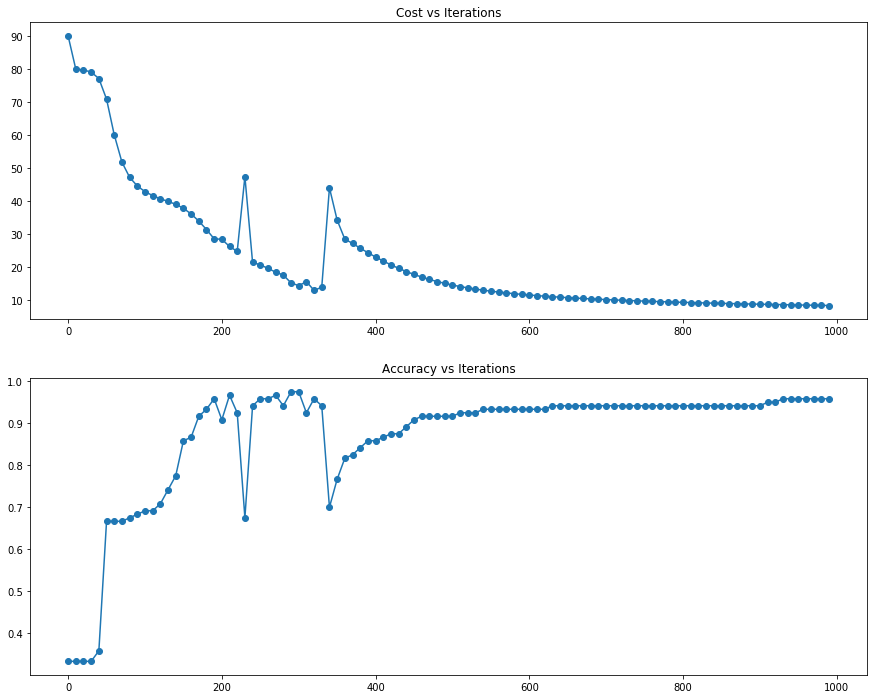

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
from simple_models.sq_error_loss_net import SquaredErrorLossNetwork
from simple_models.data_util import load_iris_data
from matplotlib import pyplot

# Load the data
xtr, ytr = load_iris_data('simple_models/datasets/iris_train.csv')
xte, yte = load_iris_data('simple_models/datasets/iris_test.csv')

input_dim, hidden_dim, output_dim = xtr.shape[1], 5, ytr.shape[1]

# Instantiate my neural network
network = SquaredErrorLossNetwork(input_dim, hidden_dim, output_dim)

# Train it!
test_acc = (network.predict(xte) == np.argmax(yte, axis=1)).mean()
print 'Test accuracy before training: %s' % str(test_acc)

iters, loss_hist, acc_hist = network.train(xtr, ytr, num_iters=1000, epoch=10)

test_acc = (network.predict(xte) == np.argmax(yte, axis=1)).mean()
print 'Test accuracy after training: %s' % str(test_acc)

matplotlib.rcParams['figure.figsize'] = (15,12)
pyplot.subplot(2, 1, 1)
pyplot.plot(iters, loss_hist, '-o')
pyplot.title('Cost vs Iterations')
pyplot.subplot(2, 1, 2)
pyplot.plot(iters, acc_hist, '-o')
pyplot.title('Accuracy vs Iterations')
pyplot.show()

### Results
Actually that work out pretty damn well, with 100% classification accuracy. However, it could be because my data set is small. I've only got 120 training examples and 30 test examples. Go to my github to look at the full implementation details:

https://www.github.com/calvinfeng/machine-learning-notebook